## Analysing social media data for disaster management (Flooding) in kdb+

The European Frontier Development Lab (FDL) is a public, private partnership between top academic institutions, governmental institurions and leaders in technology and Artificial Intelligence (AI). FDL aims to apply AI to problems within the space sector using cutting edge hardware and machine learning solutions. 2019 is the 3rd year Kx has been involved with this program, this year working on disaster management and response problems both in the US and Europe. 

Annually flooding events on average affect 82.6 million people worldwide across all social classes and geographic locations. The work presented in this notebook outlines a method by which we can distinguish the characteristics of tweets relating to flooding events such that the different classes of tweets can be triaged accordingly

In conjunction with this a representation of a live scoring system built on top of a kdb+ tickerplant has been produced to show how a live system could potentially function.

### Notebook Preparation

Here we load the following scripts and libraries

* Kx Natural Language Processing Library
* Kx Machine Learning Toolkit
* Custom functionality related to this use case
* Functionality to save models and a tokenizer for use in the 'live' system

In [2]:
\l nlp/init.q
\l ml/ml.q
\l ../code/fdl_disasters.q
\l ../code/token_save.p
.ml.loadfile`:init.q

In the following cell load all the required python functionality for the following purposes

* Plotting
* Manipulate the text data to conform to input for the models
* Appropriate deep learning model layers

In [4]:
npa:.p.import[`numpy]`:array
plt:.p.import[`matplotlib.pyplot]
pd :.p.import[`pandas]

// Textual data preprocessing 
token:.p.import[`keras.preprocessing.text]`:Tokenizer
pad  :.p.import[`keras.preprocessing.sequence]`:pad_sequences

kl:{.p.import[`keras.layers]x}
// Keras layers used
seq    :.p.import[`keras.models]`:Sequential
dense  :kl`:Dense
embed  :kl`:Embedding
lstm   :kl`:LSTM
spdrop1:kl`:SpatialDropout1D
dropout:kl`:Dropout

### Data loading and pre-processing 

The following cell contains functions that are used to load the datasets used and rename columns such that there is consistency in naming convention between the disparate data sources

In [3]:
nms_1:{rename[;names]("j*SSS";enlist",")0:`$":../data/floods/",x}
nms_2:{("jSSIPSf*J*S";enlist",")0:`$":../data/floods/",x}

Load data from flooding events across socio-encomic and geographical border. These events are in:

1. Colorado, USA 
2. Queensland, Australia
3. Alberta, Canada
4. The Phillipines
5. India
6. Pakistan

In [7]:
co :nms_1["Developed/2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv"]
qld:nms_1["Developed/2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv"]
alb:nms_1["Developed/2013_Alberta_floods/2013_Alberta_floods-tweets_labeled.csv"]
ph :nms_1["Developing/2012_Philipinnes_floods/2012_Philipinnes_floods-tweets_labeled.csv"]
ind:nms_2["Developing/2014_India_floods/2014_india_floods.csv"]
pac:nms_2["Developing/2014_Pakistan_floods/2014_pakistan_floods.csv"]

Next the following steps are taken.

* Create both a binary and multi-class dataset. Targets used for the creation of both a binary and multi-class model are encoded to ensure consistency between the two data-sources.
* Capital letter are lowered
* Un-labelled data is removed

In [10]:
data_b:encodetgt[co,qld,alb,ph;encodebin],encodetgt[ind,pac;encodebin]
data_m:encodetgt[co,qld,alb,ph;encodemulti],encodetgt[ind,pac;encodemulti]

data_m[`tweet_text]:data_b[`tweet_text]:lower data_m`tweet_text

inds:exec i from data_m where target<>`not_labeled
data_b:data_b@inds
data_m:data_m@inds

Set up functions and parameters for the removal of the following from the dataset
* Web links
* Retweet flags
* Numbers
* Special characters including `{?,.:}`

In [14]:
rmv_list   :("http*";"rt";"*,";"*&*";"*[0-9]*")
rmv_single :rmv_master[;",.:?!/@'";""]
rmv_hashtag:rmv_master[;"#";""]

#### Data pre-manipulation

In [13]:
5#data_m`tweet_text

"rt @dlfluegge: crazy flooding in boulder, colorado http://t.co/sg0iidqcey vi..
"here's the #boulderflood video that's circulating around. right in my old ne..
"rt @passantino: video: severe flooding hits near univ. of colorado at boulde..
"crazy flooding in boulder, colorado http://t.co/3igoyaafwe"
"thoughts and prayers out to those in boulder who may not get to amante for m..


Remove non ascii, retweet tag, numerical values, emojis and space hashtags 

In [15]:
data_m[`tweet_text]:data_b[`tweet_text]:
 (rmv_ascii rmv_custom[;rmv_list] rmv_hashtag rmv_single@) each data_m`tweet_text

#### Data post-manipulation

In [ ]:
5#data_m`tweet_text

---

## Initial data analysis steps

The purpose of this section is to take a high level look at the data both in regards to the distribution of classes, explore what underlays the classes themselves and perform some rudimentary sentiment analysis on the data to find positive and negative tweets

---

### Word cloud analysis

In the following cells we display the most commonly associated words with a number of the classes within this dataset

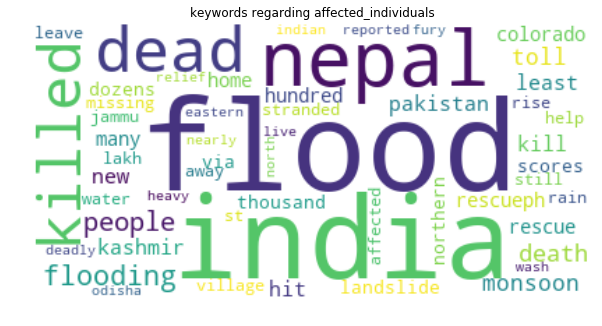

In [17]:
wordcloudfn[data_m;`affected_individuals]

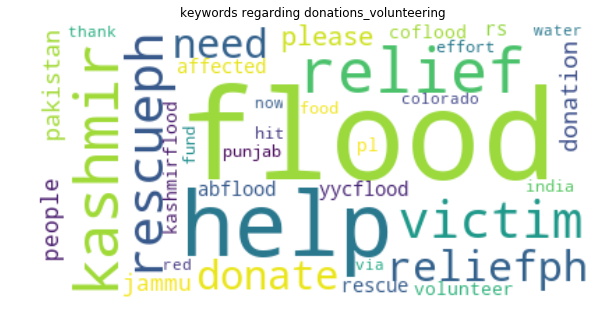

In [18]:
wordcloudfn[data_m;`donations_volunteering]

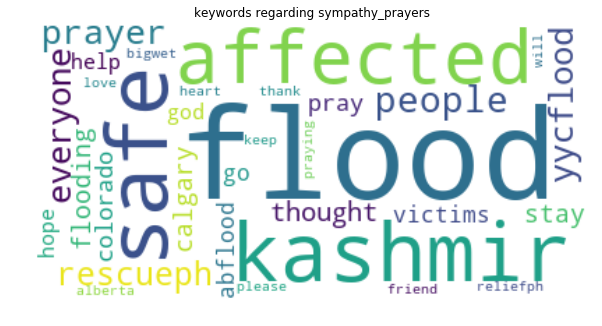

In [19]:
wordcloudfn[data_m;`sympathy_prayers]

Given the context of the tweets that within the overall dataset it is not surprising that words such as flood and locations such as Pakistan and Kashmir are displayed within a number of the classes. However some displayed words are more informative to the classes,

* donations_volunteering:
    - affected, donate, rescue, volunteer, people
* affected_individuals:
    - killed, dead, affected, missing, toll
* sympathy_prayers:
    - pray, safe, friend, thought, love
    
The presence of distinct words within each class lends credence to the idea that it should be possible to classify these tweets into their associated categories and generalise this method to new and larger datasets

---

### Sentiment analysis

The following cells outline the use of the Kx NLP library to discern positive and negative sentiments from tweets within the corpus. Below we are displaying 5 of the 100 most positive and most negative tweets in the dataset.

This allows us to gain some understanding of the state of mind of those individuals affected by the crises

In [23]:
// compute the sentiment of the tweets within the corpus
sentiments:.nlp.sentiment each data_m`tweet_text
\c 200 200
5?100#data_m[`tweet_text] iasc  sentiments`compound
5?100#data_m[`tweet_text] idesc sentiments`compound
\c 20 90

"havoc death destruction due floods in up bihar assam unacceptable after yrs of independence india needs a credible solution"
"hundreds dead as monsoon brings chaos to northern india nepal (cnn)  dozens of people have been killed in"
"flood fury in north india dozens killed lakhs affected - ndtv ndtvflood fury in north india dozens killed"
"bihar of a family killed as train hits auto - hindustan times times of indiabihar of a family killed"
"rapejihad in up continues faizabadgangrape year old hindu girl gang raped and killed hdlindiaorg"


"major_amkhan proudly serving pakistan satisfaction while helping your countrymen at the time of need help the flood victims"
"calgarypolice thank you yyc for the kind compliments this evening they will help us go through the night yycflood"
"major_amkhan proudly serving pakistan satisfaction while helping your countrymen at the time of need help the flood victims"
"joeybonifacio im encouraging those who can to help with our relief work at victoryfort tomorrow at rescueph"
"davidhurley_cdf adf is doing a great job working alongside the qld community to clean up after the flood keep up the good work"


---

### Category distribution metrics

One important aspect of training machine learning models is an understanding of the distributions of categories within the datasets. This provides a pseudo benchmark from which we can assess the ability of the models to correctly categorize differing classes.

For example in an extremely skewed binary classification model with one class `1b` comprising 95% of the target labels a model which has an accuracy on the order of 95% would not be said to have 'learnt' how to distinguish the classes as guessing that all data was labeled `1b` it would achieve this accuracy.

As a result we look at other metrics to assess the model performance such as precision, recall and f1-score which are discussed within the whitepaper which details this work from a theoretical viewpoint

##### Binary Classification 

In [24]:
distrib_b:desc count each group data_b`target

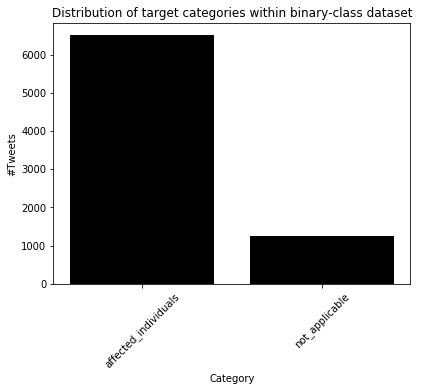

In [25]:
plt[`:bar][til count distrib_b;value distrib_b;`color pykw `k];
plt[`:title][`$"Distribution of target categories within binary-class dataset"];
plt[`:xlabel][`Category];
plt[`:xticks][til count distrib_b;key distrib_b;`rotation pykw `45];
plt[`:ylabel][`$"#Tweets"];
plt[`:show][];

##### Multi-label Classification

In [26]:
distrib_m:desc count each group data_m`target

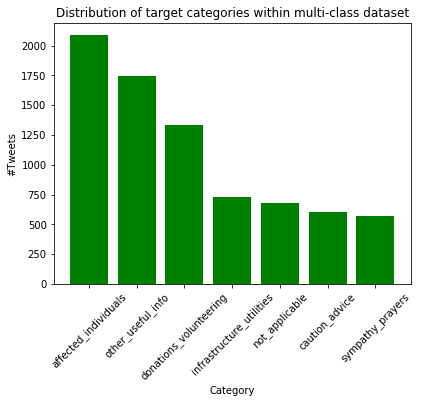

In [27]:
plt[`:bar][til count distrib_m;value distrib_m;`color pykw `g];
plt[`:title][`$"Distribution of target categories within multi-class dataset"];
plt[`:xlabel][`Category];
plt[`:xticks][til count distrib_m;key distrib_m;`rotation pykw `45];
plt[`:ylabel][`$"#Tweets"];
plt[`:show][];

---

### Model Binary-Class Disaster Management

In [28]:
batch_sz    :64
embed_dim   :100
epochs      :10
max_nb_words:2000
max_seq_len :50

In [29]:
py_data_b :npa data_b`tweet_text
tweet_vals:py_data_b

In [30]:
tokenizer:token[`num_words pykw max_nb_words;`lower pykw 1b]
tokenizer[`:fit_on_texts]tweet_vals;

sv_tok:.p.get[`save_token]
sv_tok[tokenizer]; // Save tokenizer to be used on 'live system'

In [31]:
X_b:tokenizer[`:texts_to_sequences]tweet_vals
X_b:pad[X_b;`maxlen pykw max_seq_len]`

Y_b:flip value ohe:.ml.i.onehot1 data_b`target

In [33]:
tts_b:.ml.traintestsplit[X_b;Y_b;0.1]
xtrn_b:tts_b`xtrain;ytrn_b:tts_b`ytrain
xtst_b:tts_b`xtest;ytst_b:tts_b`ytest

In [34]:
mdl_b:seq[];
mdl_b[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X_b)1]];
mdl_b[`:add]spdrop1[0.2];
mdl_b[`:add]lstm[50;pykwargs `dropout`recurrent_dropout!(0.2;0.2)];
mdl_b[`:add]dense[2;`activation pykw `softmax];
mdl_b[`:compile][pykwargs `loss`optimizer`metrics!(`categorical_crossentropy;`adam;enlist `accuracy)];
print mdl_b[`:summary][];

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 230,302
Trainable params: 230,302
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
strt:.z.t
mdl_b[`:fit][npa xtrn_b;npa ytrn_b;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;

2019-08-13 13:04:23.386638: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.



Training time = 00:05:43.947


In [30]:
class_scoring[xtst_b;ytst_b;mdl_b;ohe]


The following is the integer mapping between class integer representation and real class value:

affected_individuals| 0
not_applicable      | 1

Actual Class vs prediction

Class Prediction Hit
--------------------
0     1          0  
0     0          1  
1     1          1  
0     0          1  
0     0          1  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss      
-----| --------------------
0    | 0.94003   0.05997001
1    | 0.6666667 0.3333333 
TOTAL| 0.9019355 0.09806452

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1
-----| -------------
0    | 627    40    
1    | 36     72    

Classification report showing precision, recall and f1-score for each class:



class               | precision recall    f1_score  support
--------------------| -------------------------------------
affected_individuals| 0.9457014 0.94003   0.9428571 667    
not_applicable      | 0.6428571 0.6666667 0.6545455 108    
avg/total           | 0.7942793 0.8033483 0.7987013 775    


### Model Multi-Class Disaster Management

In [31]:
py_data_m :npa data_b`tweet_text
tweet_vals:py_data_m
tokenizer:token[`num_words pykw max_nb_words;`lower pykw 1b]
tokenizer[`:fit_on_texts][tweet_vals];

In [32]:
X_m:tokenizer[`:texts_to_sequences]tweet_vals
X_m:pad[X_m;`maxlen pykw max_seq_len]`

Y_m:flip value ohe:.ml.i.onehot1 data_m`target

In [33]:
tts_m:.ml.traintestsplit[X_m;Y_m;0.1]
xtrn_m:tts_m`xtrain;ytrn_m:tts_m`ytrain
xtst_m:tts_m`xtest;ytst_m:tts_m`ytest

In [34]:
mdl_m:seq[];
mdl_m[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X_m)1]];
mdl_m[`:add]spdrop1[0.1];
mdl_m[`:add]lstm[100;pykwargs `dropout`recurrent_dropout!(0.1;0.1)];
mdl_m[`:add]dense[7;`activation pykw `softmax];
mdl_m[`:compile][pykwargs `loss`optimizer`metrics!(`categorical_crossentropy;`adam;enlist `accuracy)];
print mdl_m[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 281,107
Trainable params: 281,107
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
strt:.z.t
mdl_m[`:fit][npa xtrn_m;npa ytrn_m;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;


Training time = 00:06:56.671


In [36]:
class_scoring[xtst_m;ytst_m;mdl_m;ohe]


The following is the integer mapping between class integer representation and real class value:

affected_individuals    | 0
caution_advice          | 1
donations_volunteering  | 2
infrastructure_utilities| 3
not_applicable          | 4
other_useful_info       | 5
sympathy_prayers        | 6

Actual Class vs prediction

Class Prediction Hit
--------------------
0     0          1  
2     2          1  
2     0          0  
4     4          1  
5     3          0  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss     
-----| -------------------
0    | 0.8598131 0.1401869
1    | 0.578125  0.421875 
2    | 0.7348485 0.2651515
3    | 0.5609756 0.4390244
4    | 0.6896552 0.3103448
5    | 0.5672515 0.4327485
6    | 0.6111111 0.3888889
TOTAL| 0.6890323 0.3109677

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1 Pred_2 Pred_3 Pred_4 Pred_5 Pred_6
-----| ------------------------------------------------
0    | 184    3      10

class                   | precision recall    f1_score  support
------------------------| -------------------------------------
affected_individuals    | 0.8214286 0.8598131 0.8401826 214    
caution_advice          | 0.5692308 0.578125  0.5736434 64     
donations_volunteering  | 0.7132353 0.7348485 0.7238806 132    
infrastructure_utilities| 0.5822785 0.5609756 0.5714286 82     
not_applicable          | 0.6896552 0.6896552 0.6896552 58     
other_useful_info       | 0.5878788 0.5672515 0.577381  171    
sympathy_prayers        | 0.6875    0.6111111 0.6470588 54     
avg/total               | 0.6644582 0.6573971 0.6604615 775    


In [ ]:
mdl_m[`:save]["../live/multiclass_mdl.h5"]

---

### Balanced classes

Looking at the distribution of classes within the main dataset it is clear that the classes are imbalanced. To reduce biases which may exist as a result of this imbalance a balanced dataset was built and a model fit with the 'improved model' in order to test improvements that could be gained from the use of a more balanced dataset

In [37]:
inds_m:raze{neg[x]?y}[min count each l]each value l:group data_m`target
bal_X_m:X_m@inds_m
bal_Y_m:Y_m@inds_m

In [38]:
bal_tts_m:.ml.traintestsplit[bal_X_m;bal_Y_m;0.1]
xtrn_m:bal_tts_m`xtrain;ytrn_m:bal_tts_m`ytrain
xtst_m:bal_tts_m`xtest;ytst_m:bal_tts_m`ytest

In [39]:
bal_mdl_m:seq[];
bal_mdl_m[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X_m)1]];
bal_mdl_m[`:add]spdrop1[0.1];
bal_mdl_m[`:add]lstm[100;pykwargs `dropout`recurrent_dropout!(0.1;0.1)];
bal_mdl_m[`:add]dense[7;`activation pykw `softmax];
bal_mdl_m[`:compile][pykwargs `loss`optimizer`metrics!(`categorical_crossentropy;`adam;enlist `accuracy)];
print bal_mdl_m[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total params: 281,107
Trainable params: 281,107
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
strt:.z.t
bal_mdl_m[`:fit][npa xtrn_m;npa ytrn_m;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;


Training time = 00:03:47.949


In [41]:
class_scoring[xtst_m;ytst_m;bal_mdl_m;ohe]


The following is the integer mapping between class integer representation and real class value:

affected_individuals    | 0
caution_advice          | 1
donations_volunteering  | 2
infrastructure_utilities| 3
not_applicable          | 4
other_useful_info       | 5
sympathy_prayers        | 6

Actual Class vs prediction

Class Prediction Hit
--------------------
2     5          0  
4     6          0  
5     1          0  
5     5          1  
0     0          1  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss     
-----| -------------------
0    | 0.7323944 0.2676056
1    | 0.640625  0.359375 
2    | 0.6923077 0.3076923
3    | 0.52      0.48     
4    | 0.754717  0.245283 
5    | 0.4545455 0.5454545
6    | 0.6507937 0.3492063
TOTAL| 0.6448363 0.3551637

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1 Pred_2 Pred_3 Pred_4 Pred_5 Pred_6
-----| ------------------------------------------------
0    | 52     3      4 

class                   | precision recall    f1_score  support
------------------------| -------------------------------------
affected_individuals    | 0.8813559 0.7323944 0.8       71     
caution_advice          | 0.6029412 0.640625  0.6212121 64     
donations_volunteering  | 0.6923077 0.6923077 0.6923077 52     
infrastructure_utilities| 0.490566  0.52      0.5048544 50     
not_applicable          | 0.7017544 0.754717  0.7272727 53     
other_useful_info       | 0.3636364 0.4545455 0.4040404 44     
sympathy_prayers        | 0.7735849 0.6507937 0.7068966 63     
avg/total               | 0.6437352 0.6350547 0.6366548 397    


---